In [ ]:
using Pkg
Pkg.activate("NB05")

In [2]:
using MLDatasets
using Plots, LinearAlgebra, Statistics
using Images, ImageCore
using JuMP, NLopt, Flux 

*Warning:* For this notebook I had to pin `CSV.jl` to version 0.8.5, because otherwise `MLDatasets` would not compile. This restricts `MLDatasets` to version 0.5. The latest version has a different syntax than the one used here.

# Classification

We consider the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset from [Zalando Research](https://github.com/zalandoresearch).

It contains images of Fashion items from 9 categories.

In Julia this dataset can be loaded through the [MLDatasets](https://github.com/JuliaML/MLDatasets.jl) package.

In [61]:
X_all, Y_all = FashionMNIST.traindata();

Now, `X_all` contains the input data and `Y_all` the output data of the training data in the `FashionMNIST` dataset.

The entries of `Y_all` correspond to the following categories:

In [62]:
labels = ["T-shirt/top", 
            "Trouser", 
            "Pullover", 
            "Dress", 
            "Coat", 
            "Sandal", 
            "Shirt", 
            "Sneaker", 
            "Bag", 
            "Ankle boot"];

Since `Julia` indexing starts at `1` and `Y_all` contains values between `0` and `9`, it will be convenient to add 1 to all values `Y_all`.  

In [63]:
Y_all = Y_all .+ 1;

Let us take a look at 6 randomly chosen images along with their labels.

["Ankle boot", "T-shirt/top", "Sandal", "Ankle boot", "Sneaker", "T-shirt/top"]


,,,,,

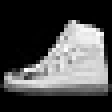
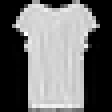
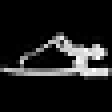
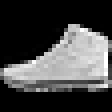
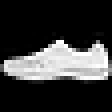
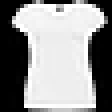

In [64]:
k = rand(1:60000, 6)
println(["$(labels[Y_all[i]])" for i in k])
[FashionMNIST.convert2image(X_all[:,:,i]) for i in k]

## Choosing two categories

To illustrate how the classification methods from the lecture work we consider only two items, namely Coats and Sandals. The goal is to learn an algorithm that can distinguish pictures from these two categories.

First, we compute the locations of Coats and Sandals in the data.

In [65]:
l₁ = findfirst(labels .== "Coat")
l₂ = findfirst(labels .== "Sandal")
l = findall(y -> y == l₁ || y == l₂, Y_all);
length(l)

12000

I.e., there are 12000 items in the data, which are either Coats or Sandals.

For training let us consider a subsample of size $n=50$. 

Since the goal of this notebook is to illustrate how classification works, we will not stick to the algorithm for approaching machine learning problems. We will simply take the first $n$ items in the data set (instead of choosing them randomly). We also take another $n$ items for testing. 

In [66]:
n = 50

50

Now, we split the data into the training and test data

In [67]:
train_indices = l[1:n];
test_indices = l[n+1:2*n];

X_test = X_all[:, :, test_indices]
Y_test = Y_all[test_indices];

X = X_all[:, :, train_indices]
Y = Y_all[train_indices];

Let us look at a subsample of the training data:

["Coat", "Coat", "Sandal", "Sandal", "Coat", "Sandal"]


,,,,,

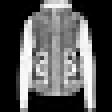
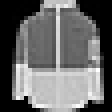
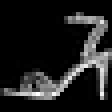
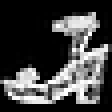
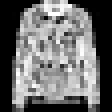
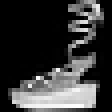

In [68]:
k = rand(1:n, 6)
println(["$(labels[Y[i]])" for i in k])
[FashionMNIST.convert2image(X[:,:,i]) for i in k]

## Visualizing the data

Each input data point is an image consisting of grey values for $28\times 28$ pixels.

Thus the data lives in $\mathbb R^D$ with $D=28^2 = 784$.

In [69]:
D = 28^2

784

Let us look at the structure of the first input data point:

In [70]:
typeof(X[:,:,1])

Matrix{N0f8} (alias for Array{Normed{UInt8, 8}, 2})

We see that the input data consists of matrices. 

For using machine learning algorithm we first transform the input data points into vectors using the `vec` function.

In [71]:
X_vec = [Float64.(vec(X[:,:,i])) for i in 1:n];
X_test_vec = [Float64.(vec(X_test[:,:,i])) for i in 1:n];

We also normalize the data to account for numerical accuracy.

In [72]:
M = maximum(norm.(X_vec))
X_vec = X_vec ./ M
X_test_vec = X_test_vec ./ M;

We can visualize this data by randomly projecting the points in $\mathbb R^D$ to $\mathbb R^2$. 

For instance, we can first center the data and then sample a random projection matrix:

In [73]:
x̄ = mean(X_vec)
Pr = randn(2, D)
X_Pr = hcat(map(x -> Pr*(x - x̄), X_vec)...);

We can now apply a scatter plot the the projected data.

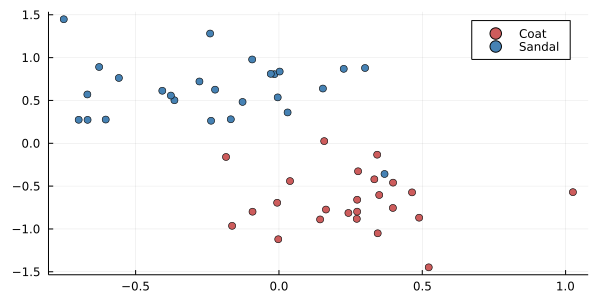

In [74]:
scatter(X_Pr[1, Y .== l₁], X_Pr[2, Y .== l₁], 
            color = :indianred,
            label = labels[l₁],
            size = (800,300))
scatter!(X_Pr[1, Y .== l₂], X_Pr[2, Y .== l₂], 
            color = :steelblue,
            label = labels[l₂],
            size = (600,300))

## Support Vector Machine

The first attempt to learn an algorithm for classification is using an SVM.

We will use the simple kernel that gives back the standard inner product between data points.

In [75]:
κ(x₁,x₂) = x₁ ⋅ x₂

κ (generic function with 1 method)

The kernel defines a kernel matrix as follows:

In [76]:
G = [κ(x₁,x₂) for (x₁,x₂) in Iterators.product(X_vec,X_vec)];

We also need to transform the output data so that it takes values in $\{-1,1\}$.

In [77]:
y = map(Y) do Yᵢ
    if Yᵢ==l₁
        -1
    elseif Yᵢ==l₂
        1
    end
    end;

We are now ready to set up the optimization problem solving the Dual SVM.

The regularization parameter is set to $C=5$.

We use [JuMP](https://jump.dev/JuMP.jl/stable/) for setting up the model and [NLopt](https://github.com/JuliaOpt/NLopt.jl) for solving the optimization problem.

In [78]:
C = 5;
model = Model(NLopt.Optimizer)

set_optimizer_attribute(model, "algorithm", :AUGLAG)
set_optimizer_attribute(model, "local_optimizer", :LD_LBFGS)

@variable(model, α[1:n]);

The constraints are defined next:

In [79]:
@constraint(model, c₁, sum(y .* α) .== 0);
@constraint(model, c₂, α .>= zeros(n));
@constraint(model, c₃, α .<= C .* ones(n));

Finally, we define the objective function.

In [80]:
@objective(model, Min, 
           4 * sum(α) - sum(y[i]*α[i]*y[j]*α[j]*G[i,j] 
            for (i,j) in Iterators.product(1:n,1:n)));

Using the following command we can now solve the optimization problem 

In [81]:
JuMP.optimize!(model)

We use the optimal value to define $\psi$ and $b$ for our SVM.

In [82]:
α_opt = value.(α);
ψ(x) =  sum(0.5 * y[i] * α_opt[i] * κ(x, X_vec[i]) for i in 1:n)
b = median(abs(y[i] - ψ(X_vec[i])) for i in 1:n if abs(α_opt[i]) > 1e-8)

8.056516850561867

This defines the following function for classification.

In [83]:
f_class(x) = Int(sign(ψ(x) + b))

f_class (generic function with 1 method)

We can use `f_class` in a prediction function:

In [84]:
function predict(f, x)
    if f(x) == -1
        println("This is a $(labels[l₁]):")
    elseif f(x) == 1
         println("This is a $(labels[l₂]):")
    end
end

predict (generic function with 1 method)

#### How well does our prediction function work?

We can now check the quality of our prediction function.

For instance, we can randomly choose items from the test data and let our algorithm predict what item it is.

This is a Coat:


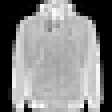

In [85]:
ℓ = rand(1:n)
predict(f_class, X_test_vec[ℓ])
FashionMNIST.convert2image(X_test[:,:,ℓ])

As a second check, we plot projected test data points along with our predictions. 


In [86]:
x̄_test = mean(X_test_vec);
X_test_Pr = hcat(map(x -> Pr*(x - x̄_test), X_test_vec)...);


For this, we produce $y_{\mathrm{test}}\in\{-1,1\}$ for the true labels and $\hat{y}_{\mathrm{test}}$ is the vector of predictions 

In [87]:
y_test = map(Y_test) do y
    if y==l₁
        -1
    elseif y==l₂
        1
    end
    end;
ŷ_test = map(f_class, X_test_vec);

The visualization comes next:

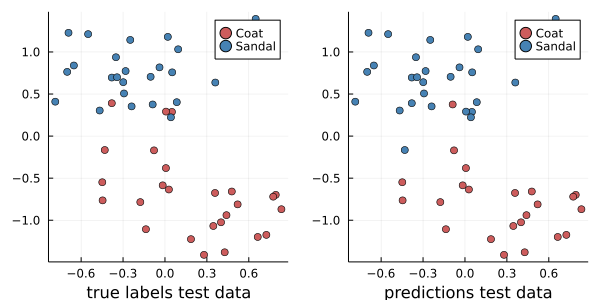

In [88]:
scatter(X_test_Pr[1, y_test .== -1], X_test_Pr[2, y_test .== -1], 
            color = :indianred,
            label = labels[l₁],
            size = (600,300),
            subplot = 1, layout = 2,
            xlabel = "true labels test data")
scatter!(X_test_Pr[1, y_test .== 1], X_test_Pr[2, y_test .== 1], 
            color = :steelblue,
            label = labels[l₂],
            subplot = 1, layout = 2)
scatter!(X_test_Pr[1, ŷ_test .== -1], X_test_Pr[2, ŷ_test .== -1], 
            color = :indianred,
            label = labels[l₁],
            size = (600,300),
            subplot = 2, layout = 2,
            xlabel = "predictions test data")
scatter!(X_test_Pr[1, ŷ_test .== 1], X_test_Pr[2, ŷ_test .== 1], 
            color = :steelblue,
            label = labels[l₂],
            subplot = 2, layout = 2)

The fraction of correctly prediced data points is

In [89]:
count(y_test-ŷ_test .!= 0)/n

0.1

# Neural Networks

We will now compute a classification algorithm using a neural network.

Instead of setting up the network by hand as we did in Notebook 4, we will use [Flux.jl](https://fluxml.ai).

We set up a neural network with three layers.

The first layer is $\mathbb R^D\to\mathbb R^{N_1}$. 

The second layer is $\mathbb R^{N_1}\to\mathbb R^{N_2}$. 

The third layer is $\mathbb R^{N_2}\to\mathbb R^{2}$.

The output in $\mathbb R^{2}$ will be a discrete probability distribution for our two items. Therefore, we use as the activation function in the last layer the softmax function. The other activation functions are chosen to be the ReLu function.

In [90]:
N₁, N₂ = 20, 15

NN = Flux.Chain(
          Dense(28^2, N₁, relu),
          Dense(N₁, N₂, relu),
          Dense(N₂, 2),
          softmax)

Chain(
  Dense(784 => 20, relu),               # 15_700 parameters
  Dense(20 => 15, relu),                # 315 parameters
  Dense(15 => 2),                       # 32 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 16_047 parameters, 63.059 KiB.

We have to modify the output data accordingly.

In [91]:
y₀ = map(Y) do Yᵢ
    if Yᵢ==l₁
        [1;0]
    elseif Yᵢ==l₂
        [0;1]
    end
    end;

As loss function we take the [crossentropy](https://en.wikipedia.org/wiki/Cross_entropy) function `ℓ(p,q) = -p₁ log(q₁) - p₂ log(q₂).`

In [92]:
loss(x, y) = Flux.crossentropy(NN(x), y; dims = 2);
# in Flux.jl the first variable is in ℝ^D

The framework to set up a Flux.jl' model is as follows:

(The code is adapted from the lecture on [Neural Nets](https://github.com/JuliaAcademy/DataScience/blob/main/10.%20Neural%20Nets.ipynb) by [Huda Nassar](https://github.com/nassarhuda).)

In [93]:
ps = Flux.params(NN);
dataset = [(Float32.(x),y) for (x,y) in zip(X_vec, y₀)];
opt = ADAM();

The model is the trained using Flux.jl's `train!` function.

In [94]:
Flux.@epochs 3 Flux.train!(loss, ps, dataset, opt)

┌ Info: Epoch 1
└ @ Main /Users/pb/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 2
└ @ Main /Users/pb/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 3
└ @ Main /Users/pb/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


Let us now see what the algorithm that we have learned predicts on randomly chosen elements from the test data set.

With probability 0.247392214813419: Coat.

With probability 0.752607785186581: Sandal.



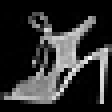

In [95]:
ℓ = rand(1:n)
p = NN(X_test_vec[ℓ])
println("With probability $(p[1]): Coat.\n")
println("With probability $(p[2]): Sandal.\n")
FashionMNIST.convert2image(X_test[:,:,ℓ])

Finally, we consider again the projected data and compare the labels from the neural network to the true labels on the test data.

The size of the points should be proportional to the probability returned from the neural network.

In [118]:
sizes = map(x->maximum(NN(x)), X_test_vec) .* 6
ŷ₀_test = map(x->argmax(NN(x)), X_test_vec);

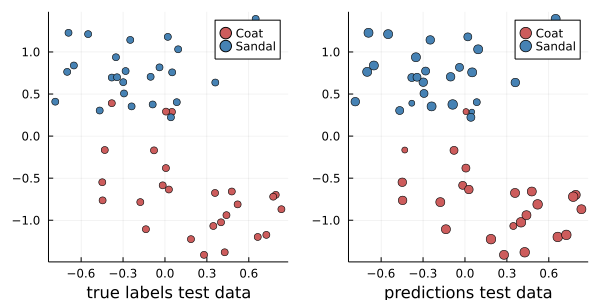

In [119]:
scatter(X_test_Pr[1, y_test .== -1], X_test_Pr[2, y_test .== -1], 
            color = :indianred,
            label = labels[l₁],
            size = (600,300),
            subplot = 1, layout = 2,
            xlabel = "true labels test data")
scatter!(X_test_Pr[1, y_test .== 1], X_test_Pr[2, y_test .== 1], 
            color = :steelblue,
            label = labels[l₂],
            subplot = 1, layout = 2)
scatter!(X_test_Pr[1, ŷ₀_test .== 1], X_test_Pr[2, ŷ₀_test .== 1], 
            color = :indianred,
            label = labels[l₁], subplot = 2,
            size = (600,300), markersizes = sizes[ŷ₀_test .== 1],
            xlabel = "predictions test data")
scatter!(X_test_Pr[1, ŷ₀_test .== 2], X_test_Pr[2, ŷ₀_test .== 2], 
            color = :steelblue, subplot = 2, markersizes = sizes[ŷ₀_test .== 2],
            label = labels[l₂])